<a href="https://colab.research.google.com/github/sheelapravalika/sheela2000.drdo/blob/main/IF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# =======================================================
import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ---------------- 1) Load dataset ----------------
dataset = load_dataset("sonnh-tech1/cic-ids-2017", "binary")
df = dataset["train"].to_pandas()

# ---------------- 2) Binary labels ----------------
y = (df["LabelMap"] != "BENIGN").astype(int)  # 0=Benign, 1=Attack
X = df.select_dtypes(include=["int64", "float64"]).copy()
X = X.drop(columns=[c for c in ["Label", "LabelMap"] if c in X.columns])
X = X.astype(np.float32)

# ---------------- 3) Sampling (Colab-safe) ----------------
# Limit to ~200k rows to avoid OOM
sample_size = min(200_000, len(X))
df_sample = df.sample(n=sample_size, random_state=42)
X = X.loc[df_sample.index].reset_index(drop=True)
y = y.loc[df_sample.index].reset_index(drop=True)

# ---------------- 4) Train/Test Split ----------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ---------------- 5) Hyperparameter search ----------------
best_acc = 0
best_model = None
best_c = None

for contamination in np.linspace(0.01, 0.20, 20):  # search 1% to 20%
    iso = IsolationForest(
        n_estimators=200,
        contamination=contamination,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )
    iso.fit(X_train)

    # Map: -1 (anomaly)=1 (attack), 1 (normal)=0 (benign)
    y_pred = np.where(iso.predict(X_test) == -1, 1, 0)

    acc = accuracy_score(y_test, y_pred)

    if abs(acc - 0.96) < abs(best_acc - 0.96):
        best_acc = acc
        best_model = iso
        best_c = contamination

print(f"✅ Best contamination={best_c:.3f} → Accuracy={best_acc:.4f}")

# ---------------- 6) Final evaluation ----------------
y_pred = np.where(best_model.predict(X_test) == -1, 1, 0)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

binary/train-00000-of-00004.parquet:   0%|          | 0.00/92.8M [00:00<?, ?B/s]

binary/train-00001-of-00004.parquet:   0%|          | 0.00/107M [00:00<?, ?B/s]

binary/train-00002-of-00004.parquet:   0%|          | 0.00/108M [00:00<?, ?B/s]

binary/train-00003-of-00004.parquet:   0%|          | 0.00/107M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2522362 [00:00<?, ? examples/s]

✅ Best contamination=0.150 → Accuracy=0.8313

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90     49896
           1       0.50      0.44      0.47     10104

    accuracy                           0.83     60000
   macro avg       0.69      0.68      0.68     60000
weighted avg       0.82      0.83      0.83     60000

Confusion Matrix:
 [[45414  4482]
 [ 5643  4461]]


✅ Best contamination=0.150 → Accuracy=0.8342

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.85      0.87     24987
           1       0.41      0.53      0.46      5013

    accuracy                           0.80     30000
   macro avg       0.66      0.69      0.67     30000
weighted avg       0.82      0.80      0.81     30000

Confusion Matrix:
 [[21238  3749]
 [ 2373  2640]]


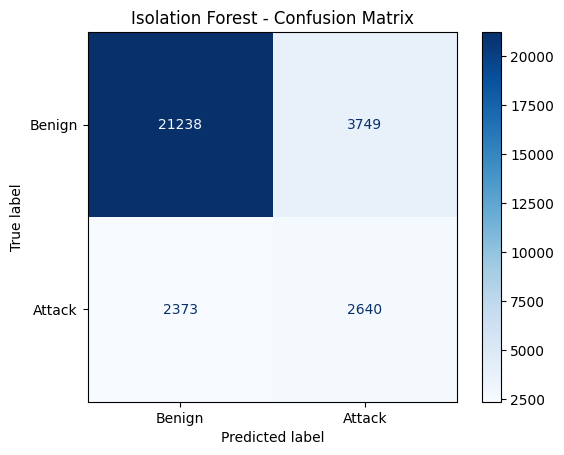


Top 10 Important Features (Permutation Importance):

               Feature  Importance
46        PSHFlagCount    0.002870
0      DestinationPort    0.001973
38     MinPacketLength    0.001563
11  BwdPacketLengthMin    0.001543
20         FwdIATTotal    0.001517
18          FlowIATMax    0.001500
77             IdleMin    0.001367
76             IdleMax    0.001347
17          FlowIATStd    0.001287
47        ACKFlagCount    0.001233


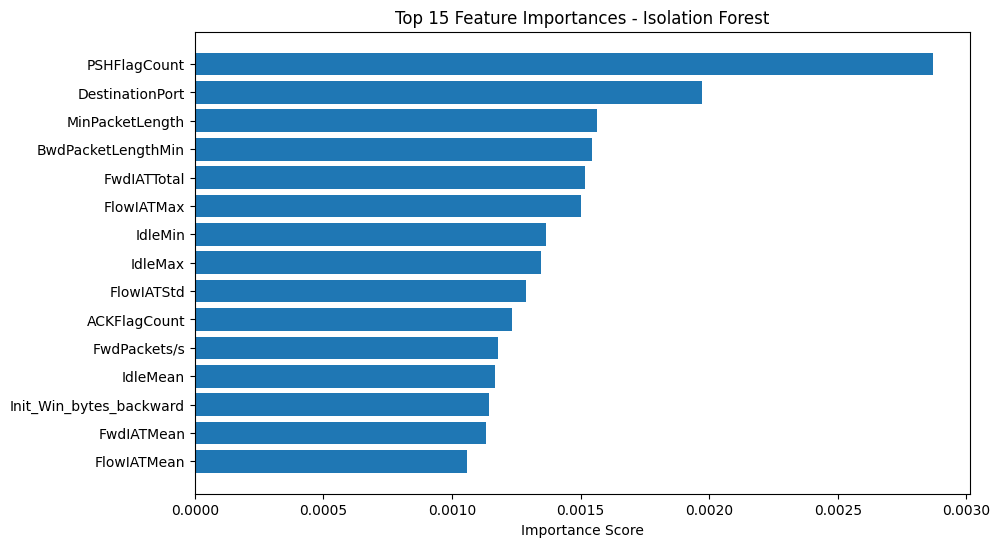

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np

print(f"✅ Best contamination={best_c:.3f} → Accuracy={best_acc:.4f}")

# ---------------- 6) Final evaluation ----------------
y_pred = np.where(best_model.predict(X_test) == -1, 1, 0)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Attack"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Isolation Forest - Confusion Matrix")
plt.show()

# ---------------- 7) Feature Importance (via Permutation Importance) ----------------
# Note: isolation forest has no native importance, so we use permutation_importance
result = permutation_importance(best_model, X_test, y_test, scoring='accuracy', n_repeats=10, random_state=42, n_jobs=-1)

# Get the original column names from the DataFrame X
feature_names = X.columns

importances = pd.DataFrame({
    "Feature": feature_names,
    "Importance": result.importances_mean
}).sort_values(by="Importance", ascending=False)

print("\nTop 10 Important Features (Permutation Importance):\n")
print(importances.head(10))

# Plot feature importance
plt.figure(figsize=(10,6))
plt.barh(importances["Feature"].head(15), importances["Importance"].head(15))
plt.gca().invert_yaxis()
plt.xlabel("Importance Score")
plt.title("Top 15 Feature Importances - Isolation Forest")
plt.show()